# Blind Spot Detection using Transfer Learning & MobileNetV2 
Using tranfer learning to create an accurate and speedy model which can perform blind spot detection (BSD) for motorcycles. 

Note that your results may vary after running the notebook.

Written by Aritro Saha, 2021 ([Github](https://github.com/AritroSaha10), [Portfolio](https://aritrosaha10.github.io/)). 

## General Information

### What is a blind spot?
As defined by Wikipedia, the blind spot of a vehicle (in this case, a motorcycle) is the area around the vehicle that cannot be directly observed by the driver while at the controls without other tools. 

This area is usually the driver's side and rear, with the actual distance depending on the vehicle.

### Goal
Create a machine learning model that given an image taken from the helmet's dedicated BSD cameras, accurately and quickly detects whether a vehicle is in the blindspot of a car or not.

### Dataset
The dataset being used is a custom one made specifically for this project. In this dataset, there are approximately 11000 images of two classes, **car in blindspot**, and **no car in blindspot**. The vast amount of images should allow the robot to be accustomed to a variety of conditions. Samples of the dataset can be found later on.

## Code

In [1]:
# Important
import numpy as np
import os

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Graphing imports
import matplotlib.pyplot as plt
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
sns.set_theme() # Set seaborn theme for nicer graphs

### Data Processing
It is assumed that the dataset is already downloaded.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
CLASS_NAMES = ["Car", "No Car"]

full_dataset = image_dataset_from_directory("labelledImgs", 
                                            batch_size=BATCH_SIZE, 
                                            image_size=IMG_SIZE
                                           )

DATASET_SIZE = tf.data.experimental.cardinality(full_dataset).numpy()

Show the first nine images in the dataset.

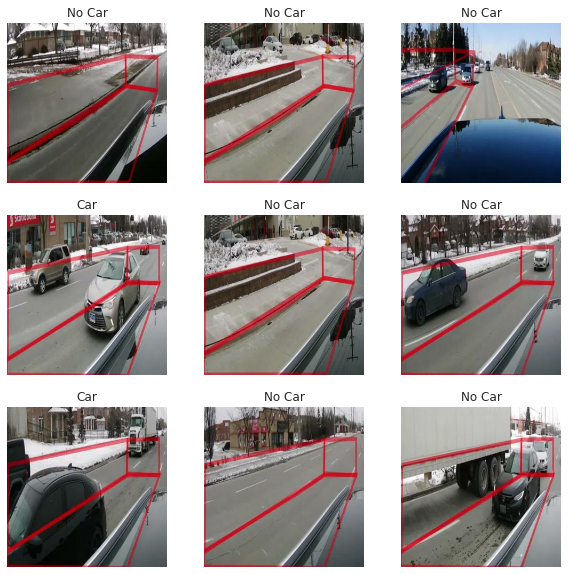

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in full_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

Split the full dataset into three datasets, `train`, `test`, and `validation`. These three datasets will have an `70% : 15% : 15%` split respectively.

In [5]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
validation_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [6]:
print('Number of train batches: %d' 
      % tf.data.experimental.cardinality(train_dataset))

print('Number of test batches: %d' 
      % tf.data.experimental.cardinality(test_dataset))

print('Number of validation batches: %d' 
      % tf.data.experimental.cardinality(validation_dataset))

Number of train batches: 257
Number of test batches: 55
Number of validation batches: 56


Use buffered prefetching to load images from disk without having the I/O become blocking. This increases the data throughput when training.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation
Unfortunately, the dataset does not include images from the other side of the car that was used to collect the images found in the dataset. Since this could have disasterous effects in the performance on the other camera, data augmentation tools provided by the TensorFlow library can be used. Data Augmentation also helps combat against overfitting.

Note that this layer is only used during training and is not utilized during inferences.

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
])

The results of data augmentation can be viewed by applying the effect to a sample set of the dataset.

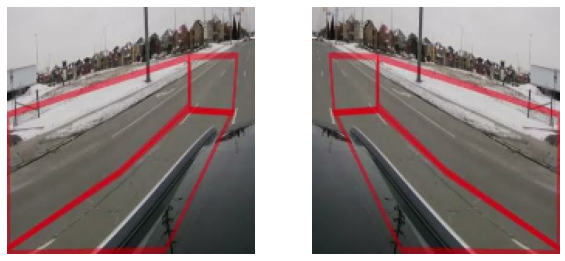

In [41]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(2):
    ax = plt.subplot(2, 2, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values
While MobileNetV2 expects its pixel data from a range of `[-1,1]`, the images in our dataset have a pixel value range of `[0,255]`. This can be fixed by using the preprocessing function provided by the model.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the Base Model
Now that the datasets have been prepared, the preparation of the model can start. As mentioned in the title, MobileNetV2, developed by Google, is being used due to it's speed and accuracy on edge devices. The reasoning towards choosing MobileNetV2 are covered more in-depth within the presentation.

It is important to note that the model we are using was pre-trained on the ImageNet dataset. This dataset consists of a wide variety of categories. Since the model has a general understanding of objects, this will help the understand and adapt to the classification problem given to it.

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=False, 
                                               weights='imagenet'
                                              )

### Feature Extraction
Since the model has been pre-trained, a lot of the hard work regarding feature extraction has already been done for us. Therefore, we can freeze the base obtained from the previous step and add classification layers that will be trained to solve our classification issue. 

Before that is done, the feature extractor is tested out, which converts each `(160 x 160 x 3)` image into a `(5 x 5 x 1280)` block of features.

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
# Base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head
To generate predictions from the frozen feature extraction layers, we will add two layers. The first layer converts the features into a 1280-element vector. The second layer will feed this vector into a fully connected layer with one neuron at the end. This neuron will output its results with sigmoid activation. 

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [16]:
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
prediction_batch = prediction_layer(feature_batch_average)

Finally, the building of the model can be finished by linking together the layers created. These layers include the data augmentation, rescaling, base model, feature extractor layer, and prediction layer.

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Set to false to make sure weights aren't changed
x = global_average_layer(x)

x = tf.keras.layers.Dropout(0.2)(x) # Helps prevent overfitting

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model
Compile the model before training it. Since there are only two classes, binary cross-entropy loss is used.

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

## Train the model
After training for 10 epochs, it should have a 94% - 95% accuracy.

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

56/56 [==============================] - 23s 100ms/step - loss: 0.8437 - accuracy: 0.4179


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.43


Setup Keras callbacks to track progress of model. 

In [22]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    # tf.keras.callbacks.ModelCheckpoint(filepath='mobilenetv2.{epoch:02d}-{val_loss:.2f}.tf'),
    # tf.keras.callbacks.TensorBoard(log_dir='./mobilenetv2_logs'),
] # Commented for now since this will overwrite my directories

In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    use_multiprocessing=True,
                    workers=7,
                    callbacks=my_callbacks)

Epoch 1/10
257/257 [==============================] - 67s 190ms/step - loss: 0.5157 - accuracy: 0.7471 - val_loss: 0.3644 - val_accuracy: 0.8549
Epoch 2/10
257/257 [==============================] - 65s 189ms/step - loss: 0.3487 - accuracy: 0.8533 - val_loss: 0.2897 - val_accuracy: 0.8795
Epoch 3/10
257/257 [==============================] - 58s 183ms/step - loss: 0.3005 - accuracy: 0.8751 - val_loss: 0.2690 - val_accuracy: 0.8934
Epoch 4/10
257/257 [==============================] - 59s 182ms/step - loss: 0.2733 - accuracy: 0.8857 - val_loss: 0.2514 - val_accuracy: 0.8934
Epoch 5/10
257/257 [==============================] - 58s 177ms/step - loss: 0.2530 - accuracy: 0.8951 - val_loss: 0.2434 - val_accuracy: 0.9035
Epoch 6/10
257/257 [==============================] - 62s 180ms/step - loss: 0.2378 - accuracy: 0.9045 - val_loss: 0.1948 - val_accuracy: 0.9247
Epoch 7/10
257/257 [==============================] - 56s 173ms/step - loss: 0.2297 - accuracy: 0.9122 - val_loss: 0.2019 - val_ac

## Learning graphs
Let's take a look at the progress of the model when training. Note that for now, the MobileNetV2 base model is being used as a fixed feature extractor.

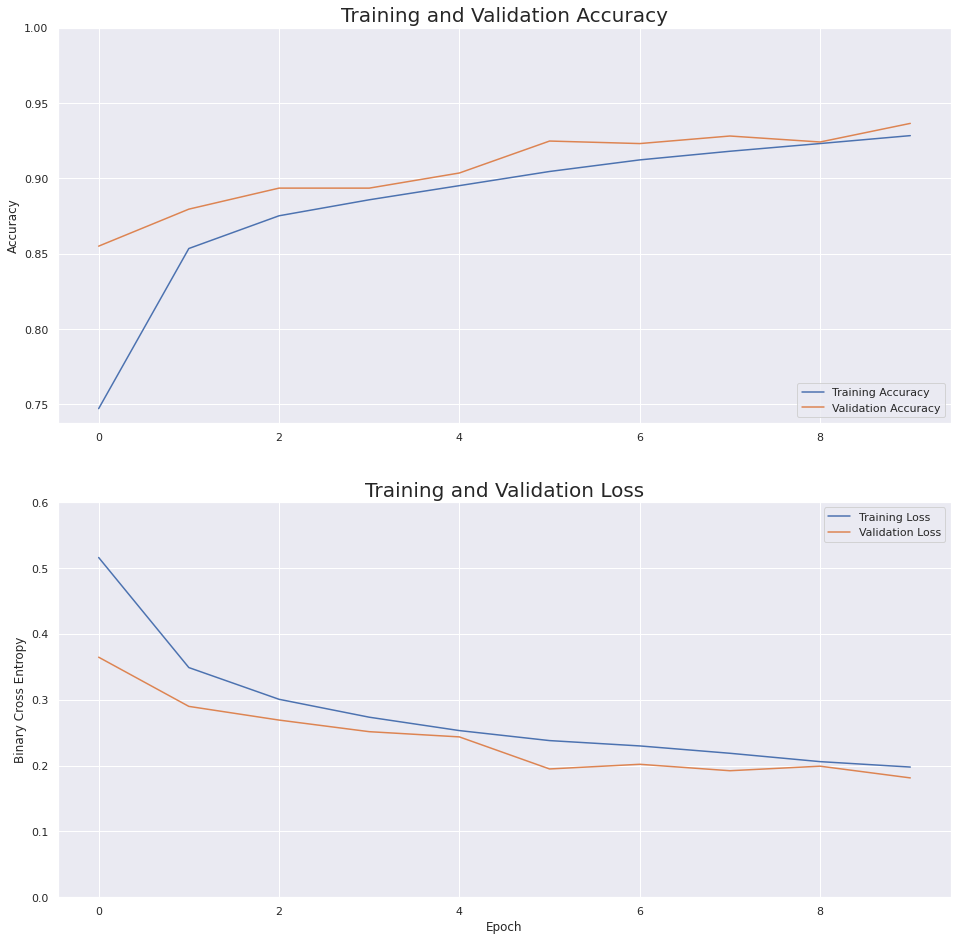

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,0.6])
plt.title('Training and Validation Loss', fontsize=20)
plt.xlabel('Epoch')
plt.show()

Note that the training statistics may be worse due to the dropout layer. As shown in the validation statistics, these layers are turned off during inferences.

## Fine tuning
Now that the model has been trained on MobileNetV2 as a fixed feature extractor, the layers at the top which extract very specific features can be unlocked to adapt the model even more to the issue at hand.

Let's start off with unlocking some of the base model layers.

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the Model
Since a much larger model is being trained, it is important that the learning rate is lower. Otherwise, it is very likely that the model would overfit.

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [29]:
len(model.trainable_variables)

56

### Continue training the model
After training, it should reach an accuracy of 97% - 99%. It is important to use the `EarlyStopping` Keras callback here as after it reaches convergance, it will likely plateau and possibly descend.

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=my_callbacks,
                         use_multiprocessing=True,
                         workers=7,
                         verbose=1)

Epoch 10/20
257/257 [==============================] - 78s 243ms/step - loss: 0.1676 - accuracy: 0.9411 - val_loss: 0.0990 - val_accuracy: 0.9693
Epoch 11/20
257/257 [==============================] - 74s 241ms/step - loss: 0.1123 - accuracy: 0.9615 - val_loss: 0.0973 - val_accuracy: 0.9648
Epoch 12/20
257/257 [==============================] - 68s 225ms/step - loss: 0.0890 - accuracy: 0.9695 - val_loss: 0.0687 - val_accuracy: 0.9760
Epoch 13/20
257/257 [==============================] - 71s 227ms/step - loss: 0.0882 - accuracy: 0.9704 - val_loss: 0.0583 - val_accuracy: 0.9827
Epoch 14/20
257/257 [==============================] - 67s 220ms/step - loss: 0.0748 - accuracy: 0.9755 - val_loss: 0.0584 - val_accuracy: 0.9810
Epoch 15/20
257/257 [==============================] - 69s 225ms/step - loss: 0.0736 - accuracy: 0.9775 - val_loss: 0.0693 - val_accuracy: 0.9754


### Learning curves after fine tuning
Let's look at both the learning curves after fine tuning and a smoothed version.

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

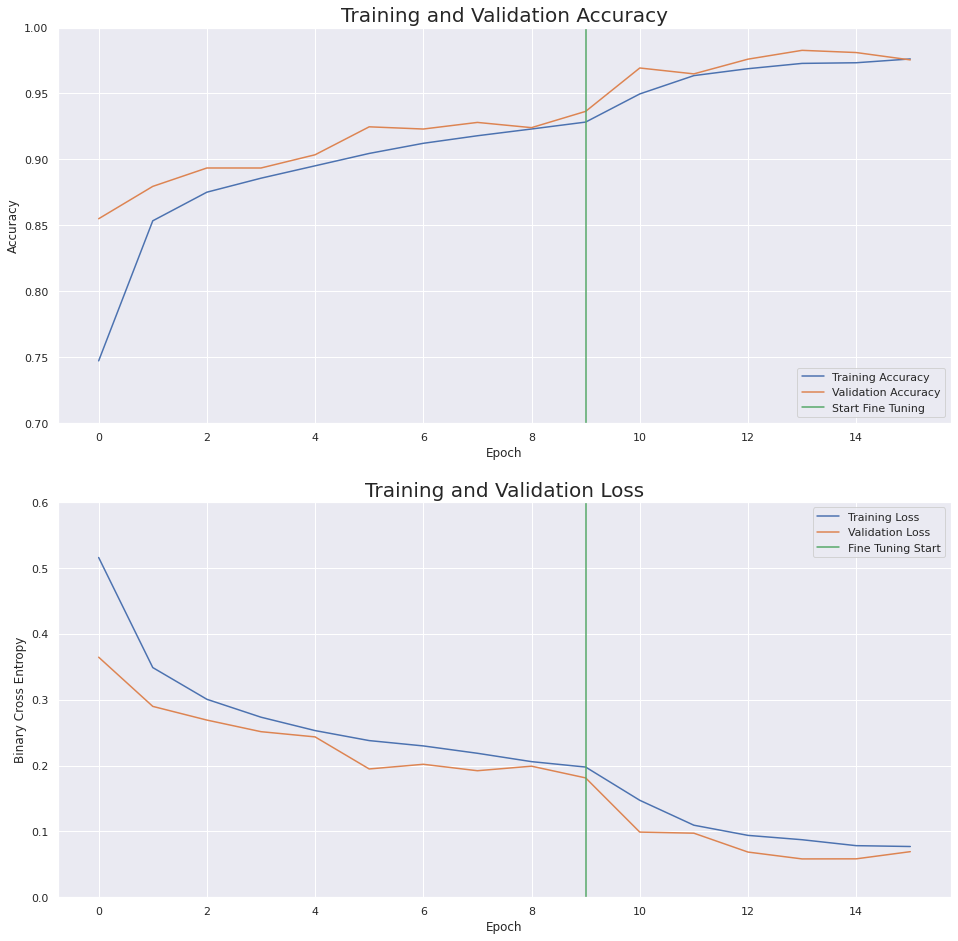

In [32]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy', fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.6])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Fine Tuning Start')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.show()

Smooth the data and create a graph from it.

In [33]:
from scipy.interpolate import splrep, splev

smooth_const = 0.01
epoch_list = [i for i in range(len(acc))]

acc_smooth = splev(epoch_list, splrep(epoch_list, acc, s=smooth_const))
val_acc_smooth = splev(epoch_list, splrep(epoch_list, val_acc, s=smooth_const))
loss_smooth = splev(epoch_list, splrep(epoch_list, loss, s=smooth_const))
val_loss_smooth = splev(epoch_list, splrep(epoch_list, val_loss, s=smooth_const))

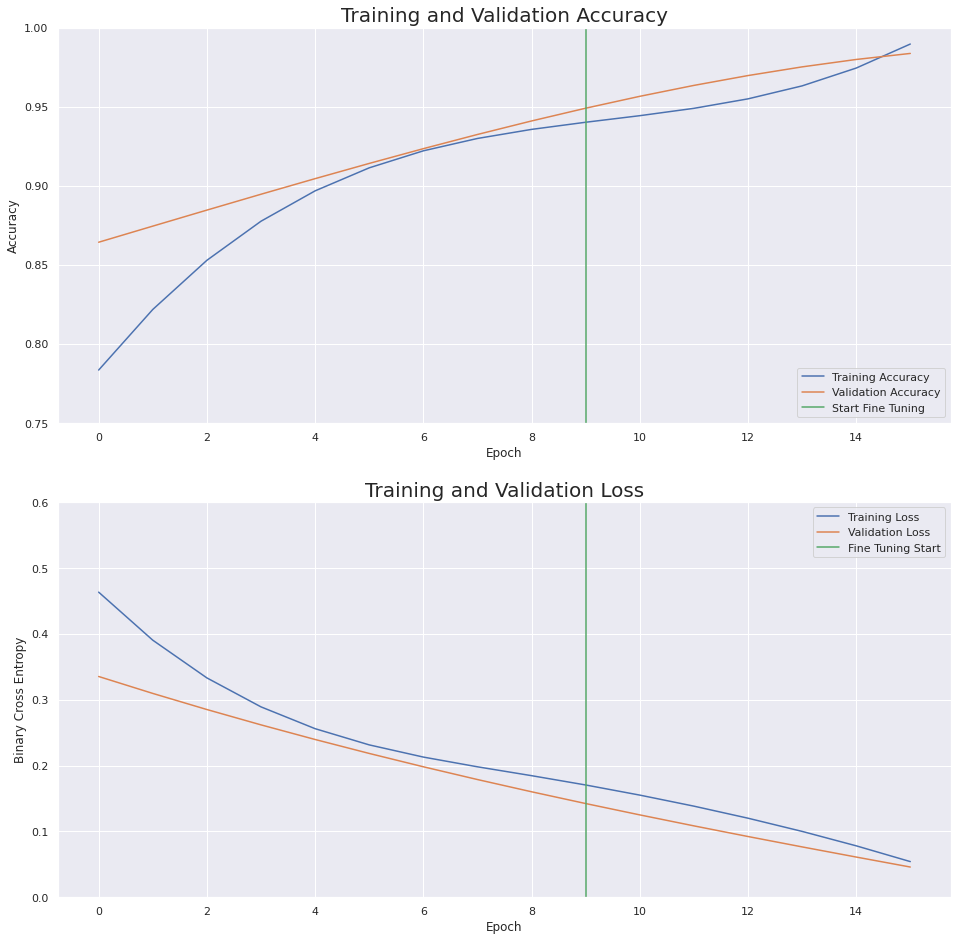

In [34]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc_smooth, label='Training Accuracy')
plt.plot(val_acc_smooth, label='Validation Accuracy')
plt.ylim([0.75, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy', fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(loss_smooth, label='Training Loss')
plt.plot(val_loss_smooth, label='Validation Loss')
plt.ylim([0, 0.6])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Fine Tuning Start')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')

plt.savefig("mobilenetv2_smooth.svg")
plt.show()

### Evaluation and Prediction
Finally, the performance of the model can be verified using the test dataset.

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

55/55 [==============================] - 18s 106ms/step - loss: 0.0551 - accuracy: 0.9801
Test accuracy : 0.9801136255264282


Run the model on the test dataset and stores the results.

In [36]:
# Retrieve a batch of images from the test dataset
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions_raw = model.predict_on_batch(image_batch).flatten()

Predictions:
 [1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1]
Labels:
 [1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1]


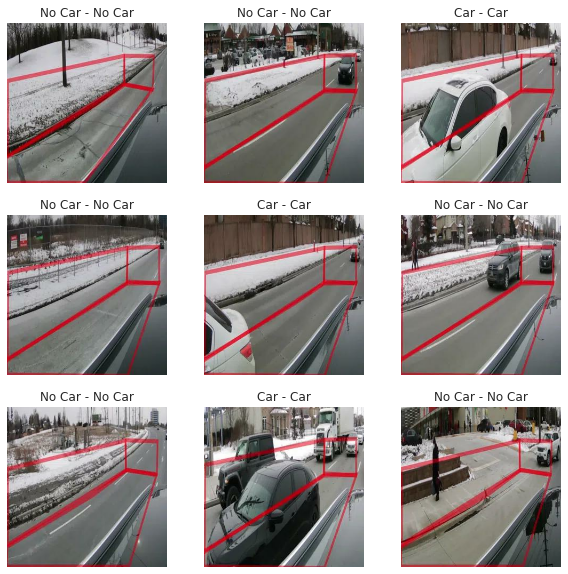

In [37]:
predictions = tf.where(predictions_raw < 0.5, 0, 1)
labels_round = tf.where(label_batch < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"{CLASS_NAMES[predictions[i]]} - {CLASS_NAMES[labels_round[i]]}")
    plt.axis("off")

## Save the Model
The model can finally be saved to a safe location so it can be used later. It should also be converted to the TFLite format later.

In [38]:
model.save("mobilenetv2_model.tf")

INFO:tensorflow:Assets written to: mobilenetv2_model.tf/assets



# Final Remarks
That concludes the process of creating a model used for blind spot detection.